 # Notebook para detecção de quebra de diálogo

In [110]:
from os.path import join as pathjoin;
from os import listdir
import os
import re
import json
import matplotlib.pyplot as plt
import pandas as pd;
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
import numpy as np
import sklearn.pipeline
from gensim.models import KeyedVectors
from sklearn.model_selection import GridSearchCV
import math,glob
from collections import Counter

import tensorflow as tf
import tensorflow.keras.backend as K
from tqdm import tqdm
import nltk
from nltk import tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Bases de desenvolvimento e teste

In [111]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [112]:
base_path = '/content/gdrive/My Drive/Mestrado/Conjuntos/DBDC4'
dev_data_path = pathjoin(base_path,'DBDC4_dev_20190312')
eval_data_path = pathjoin(base_path,'DBDC4_eval_20200314')

#output_data_path = pathjoin(base_path, 'experimento_v2_out/')
#wikpediaW2Vec = pathjoin(base_path,'wikpedia_embeddings/model.txt')
#word2vecGoogleNewsVectors = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'

dbdc3_path = '/content/gdrive/My Drive/Mestrado/English/crf_baseline/train'
dbdc3_path_2 = '/content/gdrive/My Drive/Mestrado/English/crf_baseline/test'

In [113]:
def separateEval(originPath, destinationPath, count):
    files = listdir(originPath)
    eval_files = numpy.random.choice(files,count,False)
    if not os.path.exists(destinationPath):
        os.makedirs(destinationPath)
    for file in eval_files:
        os.rename(pathjoin(originPath,file),pathjoin(destinationPath,file))

## Separando 30% em arquivos de teste

In [114]:
# Comentando para não correr o risco de rodar novamente
#separateEval(cic_dev_path,cic_eval_path,34)
#separateEval(iris_dev_path,iris_eval_path,30)
#separateEval(tktk_dev_path,tktk_eval_path,30)
#separateEval(yi_dev_path,yi_eval_path,30)

### Funções úteis

In [115]:
def loadConversations(path):
    conversations = []
    for f in listdir(path):
        if '.log.json' in f:
            json_obj = json.load(open(pathjoin(path,f), encoding='utf-8'))
            json_obj['file_name'] = f
            conversations.append(json_obj)
    return conversations

In [116]:
# O t['class'] define o voto majoritário entre os juízes em annotations
# Geração de voto majoritário para votador humano
def SetMajorityVoteAndDistribution(conversations, threshold):
    for c in conversations:
        for t in c['turns']:
            count={}
            count['O']=0
            count['T']=0
            count['X']=0
            hasAnnotations = False
            for a in t['annotations']:
                hasAnnotations = True
                count[a['breakdown']] +=1
            del t['annotations']
            if hasAnnotations:
                #distribution
                t['O'] = count['O']*1.0 / (count['O'] + count['T'] + count['X'])
                t['T'] = count['T']*1.0 / (count['O'] + count['T'] + count['X'])
                t['X'] = count['X']*1.0 / (count['O'] + count['T'] + count['X']) 
                #majorityVoting
                t['class'] = 'O'
                t['class'] = 'X' if t['X']>=t['T'] and t['X']>=t['O'] and t['X']>=threshold else t['class']
                t['class'] = 'T' if t['T']>=t['O'] and t['T']>=t['X'] and t['T']>=threshold else t['class']
                t['class'] = 'O' if t['O']>=t['T'] and t['O']>=t['X'] and t['O']>=threshold else t['class']
                
    return conversations
        

In [117]:
def ConversationClassCount(conversations):
    count={}
    count['O']=0
    count['T']=0
    count['X']=0
    for c in conversations:
        for t in c['turns']:
            if 'class' in t:
                count[t['class']] += 1
    return count

In [118]:
def printHistogram(data,name):
    print('O = not a breakdown, T = possible breakdown, and X = breakdown')
    dataSum = ConversationClassCount(data)
    plt.hist(list(dataSum.keys()), weights=list(dataSum.values()))
    plt.title(name)
    plt.show()

In [119]:
def saveJson(outputPath, fileName, data):
    fileToSave = pathjoin(outputPath, fileName.replace('.log.json','.labels.json'))
    with open(fileToSave, 'w') as file:
        #print(data)
        file.write(json.dumps(data))

In [120]:
def outputFiles(outputPath, pipeline, test):
    test.sort_values(['file_name', 'user-index'], ascending=[True, True])
    data = {}
    data['turns'] = []
    size = test.shape[0]
    predictedValues = pipeline.predict(test)
    predictedProbas = pipeline.predict_proba(test)
    for i in range(size):
        data['dialogue-id'] = test.iloc[i]['dialogue-id']
        predictedValue = predictedValues[i]
        predictedProba = predictedProbas[i]
        
        turn ={}
        turn['turn-index'] = int(test.iloc[i]['system-index'])
        turn['labels'] = []
        
        label ={}
        label['breakdown'] = predictedValue
        label['prob-O'] = predictedProba[0]
        label['prob-T'] = predictedProba[1]
        label['prob-X'] = predictedProba[2] 
        
        turn['labels'].append(label)        
        data['turns'].append(turn)
        if  i == size-1 or test.iloc[i]['file_name'] != test.iloc[i+1]['file_name']:
            saveJson(outputPath, test.iloc[i]['file_name'], data)
            data = {}
            data['turns'] = []
            
        
#outputFiles(output_data_path,pipeline, test)

In [121]:
def scoreToLabel(score):
    score_float = float(score)
    if score_float<0.4:
        return 'O'
    elif score_float <0.8:
        return 'T'
    else:
        return 'X'

In [122]:
def resultArray(pipeline, test, testPred):
    #test.sort_values(['file_name', 'user-index'], ascending=[True, True])
    result ={}
    data = {}
    data['turns'] = []
    size = test.shape[0]
    predictedValues = pipeline.predict(testPred)
    predictedProbas = pipeline.predict_proba(testPred)
    for i in range(size):
        data['dialogue-id'] = test.iloc[i]['dialogue-id']
        result[data['dialogue-id']] = data
        predictedValue = scoreToLabel(predictedValues[i])
        predictedProba = predictedProbas[i]
        
        turn ={}
        turn['turn-index'] = int(test.iloc[i]['system-index'])
        turn['labels'] = []
        
        label ={}
        label['breakdown'] = predictedValue
        label['prob-O'] = predictedProba[0]
        label['prob-T'] = predictedProba[1]
        label['prob-X'] = predictedProba[2] 
        
        turn['labels'].append(label)        
        data['turns'].append(turn)
        if  i == size-1 or test.iloc[i]['file_name'] != test.iloc[i+1]['file_name']:
            data = {}
            data['turns'] = []
    return result

## Métodos de avaliação

In [123]:
def calc_distribution(annotations) :
    count_O = 0
    count_T = 0
    count_X = 0

    for annotation in annotations:
        if annotation['breakdown'] == 'O':
            count_O += 1
        elif annotation['breakdown'] == 'T':
            count_T += 1
        elif annotation['breakdown'] == 'X':
            count_X += 1

    prob_O = count_O*1.0 / (count_O + count_T + count_X)
    prob_T = count_T*1.0 / (count_O + count_T + count_X)
    prob_X = count_X*1.0 / (count_O + count_T + count_X)

    return [prob_O, prob_T, prob_X]

In [124]:
def majority_label(prob_O, prob_T, prob_X, threshold):

    if prob_O >= prob_T and prob_O >= prob_X and prob_O >= threshold:
        return "O"
    elif prob_T >= prob_O and prob_T >= prob_X and prob_T >= threshold:
        return "T"
    elif prob_X >= prob_T and prob_X >= prob_O and prob_X >= threshold:
        return "X"
    else:
        return "O"

In [125]:
def majority_label_lenient(prob_O, prob_T, prob_X, threshold):

    if prob_O >= prob_T + prob_X and prob_O >= threshold:
        return "O_l"
    elif prob_T + prob_X >= prob_O and prob_T + prob_X >= threshold:
        return "X_l"
    else:
        return "O_l"

In [126]:
def kld(p, q):
    k = 0.0
    for i in range(len(p)):
        if p[i] > 0:
            k += p[i] * (math.log(p[i]/q[i],2))

    return k

In [127]:
def jsd(p, q):
    m = []
    for i in range(len(p)):
        m.append((p[i]+q[i])/2.0)

    return (kld(p,m) + kld(q,m)) / 2.0

In [128]:
def mse(p, q):
    total = 0.0

    for i in range(len(p)):
        total += pow(p[i] - q[i],2)

    return total / len(p)

In [129]:
def evaluation(data_path,eval_data,threshold):

    file_num = 0
    label_num = 0

    correct_num = 0
    incorrect_num = 0

    predO_ansO = 0
    predO_ansT = 0
    predO_ansX = 0
    predT_ansO = 0
    predT_ansT = 0
    predT_ansX = 0
    predX_ansO = 0
    predX_ansT = 0
    predX_ansX = 0

    predO_ansO_l = 0
    predO_ansX_l = 0
    predT_ansO_l = 0
    predT_ansX_l = 0
    predX_ansO_l = 0
    predX_ansX_l = 0

    jsd_O_T_X_sum = 0.0
    jsd_O_TX_sum = 0.0
    jsd_OT_X_sum = 0.0
    mse_O_T_X_sum = 0.0
    mse_O_TX_sum = 0.0
    mse_OT_X_sum = 0.0

    pred_dist_list = []
    ans_dist_list = []

    #parser = argparse.ArgumentParser()
    #parser.add_argument('-p', dest='datapath', action='store', metavar='TESTDIR', required=True,
                        #help='テスト用の対話データが入ったディレクトリ')
    #parser.add_argument('-o', dest='evalpath', action='store', metavar='EVALDIR', required=True,
                        #help='評価用データが入ったディレクトリ')
    #parser.add_argument('-t', dest='threshold', action='store', metavar='THRESHOLD', required=False,
                        #help='正解ラベルを決定するためのしきい値')

    #args = parser.parse_args()

    #data_path = args.datapath
    #eval_path = args.evalpath

    #threshold = 0.0
    #if args.threshold != None:
    #    threshold = float(args.threshold)

    #if not data_path.endswith('/') or not data_path.endswith('\\'):
        #data_path += '/'
    #if not eval_path.endswith('/') or not eval_path.endswith('\\'):
        #eval_path += '/'

    data_files = glob.glob(data_path + '/*log.json')
    
    for f in data_files:
    #for data_json in data_files:
        file_num += 1

        data_fp = open(f, "r")
        data_json = json.load(data_fp)
        data_fp.close()

        dlg_id = data_json["dialogue-id"]
        #eval_fp = open(eval_path + dlg_id + ".labels.json", "r")
        #eval_json = json.load(eval_fp)
        #eval_fp.close()
        
        eval_json = eval_data[dlg_id]
        #print(dlg_id)
        eval_index = 0
        for turn in data_json['turns']:
            if turn['speaker'] == "U" or turn['annotations']==[]:  # modified Sep 17 2017
                continue

            label_num += 1

            ans_prob_dist = calc_distribution(turn['annotations'])
            ans_dist_list.append(ans_prob_dist)
            ans_label = majority_label(ans_prob_dist[0], ans_prob_dist[1], ans_prob_dist[2], threshold)

            ans_label_l = majority_label_lenient(ans_prob_dist[0], ans_prob_dist[1], ans_prob_dist[2], threshold)

            #print(f)
            target_label = eval_json['turns'][eval_index]['labels'][0]

            pred_prob_dist = [float(target_label['prob-O']), float(target_label['prob-T']), float(target_label['prob-X'])]
            pred_dist_list.append(pred_prob_dist)

            jsd_O_T_X_sum += jsd(ans_prob_dist,pred_prob_dist)
            jsd_O_TX_sum += jsd([ans_prob_dist[0],ans_prob_dist[1] + ans_prob_dist[2]],[pred_prob_dist[0],pred_prob_dist[1] + pred_prob_dist[2]])
            jsd_OT_X_sum += jsd([ans_prob_dist[0] + ans_prob_dist[1],ans_prob_dist[2]],[pred_prob_dist[0] + pred_prob_dist[1] ,pred_prob_dist[2]])

            mse_O_T_X_sum += mse(ans_prob_dist,pred_prob_dist)
            mse_O_TX_sum += mse([ans_prob_dist[0],ans_prob_dist[1] + ans_prob_dist[2]],[pred_prob_dist[0],pred_prob_dist[1] + pred_prob_dist[2]])
            mse_OT_X_sum += mse([ans_prob_dist[0] + ans_prob_dist[1],ans_prob_dist[2]],[pred_prob_dist[0] + pred_prob_dist[1] ,pred_prob_dist[2]])

            pred_label = target_label['breakdown']
            eval_index += 1

            if pred_label == ans_label:
                correct_num += 1
            else:
                incorrect_num += 1

            if pred_label == "O":
                if ans_label == "O":
                    predO_ansO += 1
                elif ans_label == "T":
                    predO_ansT += 1
                elif ans_label == "X":
                    predO_ansX += 1
            elif pred_label == "T":
                if ans_label == "O":
                    predT_ansO += 1
                elif ans_label == "T":
                    predT_ansT += 1
                elif ans_label == "X":
                    predT_ansX += 1
            elif pred_label == "X":
                if ans_label == "O":
                    predX_ansO += 1
                elif ans_label == "T":
                    predX_ansT += 1
                elif ans_label == "X":
                    predX_ansX += 1

            #lenient
            if pred_label == "O":
                if ans_label_l == "O_l":
                    predO_ansO_l += 1
                elif ans_label_l == "X_l":
                    predO_ansX_l += 1
            elif pred_label == "T":
                if ans_label_l == "O_l":
                    predT_ansO_l += 1
                elif ans_label_l == "X_l":
                    predT_ansX_l += 1
            elif pred_label == "X":
                if ans_label_l == "O_l":
                    predX_ansO_l += 1
                elif ans_label_l == "X_l":
                    predX_ansX_l += 1


#     print correct_num
#     print incorrect_num
#
#     print predO_ansO
#     print predO_ansT
#     print predO_ansX
#     print predT_ansO
#     print predT_ansT
#     print predT_ansX
#     print predX_ansO
#     print predX_ansT
#     print predX_ansX


    #print str(predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l + predO_ansX_l + predO_ansO_l)

    print("######### Data Stats #########")
    print("File Num : \t\t" + str(file_num))
    print("System Utterance Num : \t" + str(label_num))
    print("O Label Num : \t\t" + str(predO_ansO + predT_ansO + predX_ansO))
    print("T Label Num : \t\t" + str(predO_ansT + predT_ansT + predX_ansT))
    print("X Label Num : \t\t" + str(predO_ansX + predT_ansX + predX_ansX))
    print("")

    print("######### Results #########")
    print("Accuracy : \t\t%4f" % ((correct_num*1.0) / (correct_num + incorrect_num)) + " (" + str(correct_num) + "/" + str(correct_num + incorrect_num) + ")\n")

    precision_s = 0.0
    recall_s = 0.0
    fmeasure_s = 0.0

    if predX_ansX > 0:
        if (predX_ansO + predX_ansT + predX_ansX) > 0:
            precision_s = predX_ansX*1.0 / (predX_ansO + predX_ansT + predX_ansX)
        if (predO_ansX + predT_ansX + predX_ansX) > 0:
            recall_s = predX_ansX*1.0 / (predO_ansX + predT_ansX + predX_ansX)

    if precision_s > 0 and recall_s > 0:
        fmeasure_s = (2*precision_s*recall_s)/(precision_s + recall_s)

    print("Precision (X) : \t%4f" % (precision_s) + " (" + str(predX_ansX) + "/" + str(predX_ansO + predX_ansT + predX_ansX) + ")")
    print("Recall    (X) : \t%4f" % (recall_s) + " (" + str(predX_ansX) + "/" + str(predO_ansX + predT_ansX + predX_ansX) + ")")
    print("F-measure (X) : \t%4f" % (fmeasure_s) + "\n")


    precision_l = 0.0
    recall_l = 0.0
    fmeasure_l = 0.0
    if (predT_ansX_l + predX_ansX_l) > 0 and (predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l) > 0:
        precision_l = (predT_ansX_l + predX_ansX_l)*1.0 / (predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l)
    if (predT_ansX_l + predX_ansX_l) > 0 and (predO_ansX_l + predT_ansX_l + predX_ansX_l) > 0:
        recall_l = (predT_ansX_l + predX_ansX_l)*1.0 / (predO_ansX_l + predT_ansX_l + predX_ansX_l)
    if precision_l > 0 and recall_l > 0:
        fmeasure_l = (2*precision_l*recall_l)/(precision_l + recall_l)



    print("Precision (T+X) : \t%4f" % (precision_l) + " (" + str(predT_ansX_l + predX_ansX_l) + "/" + str(predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l) + ")")
    print("Recall    (T+X) : \t%4f" % (recall_l) + " (" + str(predT_ansX_l + predX_ansX_l) + "/" + str(predO_ansX_l + predT_ansX_l + predX_ansX_l) + ")")
    print("F-measure (T+X) : \t%4f" % (fmeasure_l) + "\n")

    print("JS divergence (O,T,X) : \t%4f" % (jsd_O_T_X_sum / (correct_num + incorrect_num)))
    print("JS divergence (O,T+X) : \t%4f" % (jsd_O_TX_sum / (correct_num + incorrect_num)))
    print("JS divergence (O+T,X) : \t%4f" % (jsd_OT_X_sum / (correct_num + incorrect_num)) + "\n")

    print("Mean squared error (O,T,X) : \t%4f" % (mse_O_T_X_sum / (correct_num + incorrect_num)))
    print("Mean squared error (O,T+X) : \t%4f" % (mse_O_TX_sum / (correct_num + incorrect_num)))
    print("Mean squared error (O+T,X) : \t%4f" % (mse_OT_X_sum / (correct_num + incorrect_num)))
    print("###########################")

In [130]:
def evaluationAsDict(data_path,eval_data,threshold):

    file_num = 0
    label_num = 0

    correct_num = 0
    incorrect_num = 0

    predO_ansO = 0
    predO_ansT = 0
    predO_ansX = 0
    predT_ansO = 0
    predT_ansT = 0
    predT_ansX = 0
    predX_ansO = 0
    predX_ansT = 0
    predX_ansX = 0

    predO_ansO_l = 0
    predO_ansX_l = 0
    predT_ansO_l = 0
    predT_ansX_l = 0
    predX_ansO_l = 0
    predX_ansX_l = 0

    jsd_O_T_X_sum = 0.0
    jsd_O_TX_sum = 0.0
    jsd_OT_X_sum = 0.0
    mse_O_T_X_sum = 0.0
    mse_O_TX_sum = 0.0
    mse_OT_X_sum = 0.0

    pred_dist_list = []
    ans_dist_list = []

    #parser = argparse.ArgumentParser()
    #parser.add_argument('-p', dest='datapath', action='store', metavar='TESTDIR', required=True,
                        #help='テスト用の対話データが入ったディレクトリ')
    #parser.add_argument('-o', dest='evalpath', action='store', metavar='EVALDIR', required=True,
                        #help='評価用データが入ったディレクトリ')
    #parser.add_argument('-t', dest='threshold', action='store', metavar='THRESHOLD', required=False,
                        #help='正解ラベルを決定するためのしきい値')

    #args = parser.parse_args()

    #data_path = args.datapath
    #eval_path = args.evalpath

    #threshold = 0.0
    #if args.threshold != None:
    #    threshold = float(args.threshold)

    #if not data_path.endswith('/') or not data_path.endswith('\\'):
        #data_path += '/'
    #if not eval_path.endswith('/') or not eval_path.endswith('\\'):
        #eval_path += '/'

    data_files = glob.glob(data_path + '/*log.json')
    
    for f in data_files:
    #for data_json in data_files:
        file_num += 1

        data_fp = open(f, "r")
        data_json = json.load(data_fp)
        data_fp.close()

        dlg_id = data_json["dialogue-id"]
        #eval_fp = open(eval_path + dlg_id + ".labels.json", "r")
        #eval_json = json.load(eval_fp)
        #eval_fp.close()
        
        eval_json = eval_data[dlg_id]
        #print(dlg_id)
        eval_index = 0
        for turn in data_json['turns']:
            if turn['speaker'] == "U" or turn['annotations']==[]:  # modified Sep 17 2017
                continue

            label_num += 1

            ans_prob_dist = calc_distribution(turn['annotations'])
            ans_dist_list.append(ans_prob_dist)
            ans_label = majority_label(ans_prob_dist[0], ans_prob_dist[1], ans_prob_dist[2], threshold)

            ans_label_l = majority_label_lenient(ans_prob_dist[0], ans_prob_dist[1], ans_prob_dist[2], threshold)

            #print(f)
            target_label = eval_json['turns'][eval_index]['labels'][0]
            
            #print(str(ans_label)+','+str(target_label['breakdown'])+','+ str(turn['turn-index'])+','+ str(eval_json['turns'][eval_index]['turn-index']))

            pred_prob_dist = [float(target_label['prob-O']), float(target_label['prob-T']), float(target_label['prob-X'])]
            pred_dist_list.append(pred_prob_dist)

            jsd_O_T_X_sum += jsd(ans_prob_dist,pred_prob_dist)
            jsd_O_TX_sum += jsd([ans_prob_dist[0],ans_prob_dist[1] + ans_prob_dist[2]],[pred_prob_dist[0],pred_prob_dist[1] + pred_prob_dist[2]])
            jsd_OT_X_sum += jsd([ans_prob_dist[0] + ans_prob_dist[1],ans_prob_dist[2]],[pred_prob_dist[0] + pred_prob_dist[1] ,pred_prob_dist[2]])

            mse_O_T_X_sum += mse(ans_prob_dist,pred_prob_dist)
            mse_O_TX_sum += mse([ans_prob_dist[0],ans_prob_dist[1] + ans_prob_dist[2]],[pred_prob_dist[0],pred_prob_dist[1] + pred_prob_dist[2]])
            mse_OT_X_sum += mse([ans_prob_dist[0] + ans_prob_dist[1],ans_prob_dist[2]],[pred_prob_dist[0] + pred_prob_dist[1] ,pred_prob_dist[2]])

            pred_label = target_label['breakdown']
            eval_index += 1

            if pred_label == ans_label:
                correct_num += 1
            else:
                incorrect_num += 1

            if pred_label == "O":
                if ans_label == "O":
                    predO_ansO += 1
                elif ans_label == "T":
                    predO_ansT += 1
                elif ans_label == "X":
                    predO_ansX += 1
            elif pred_label == "T":
                if ans_label == "O":
                    predT_ansO += 1
                elif ans_label == "T":
                    predT_ansT += 1
                elif ans_label == "X":
                    predT_ansX += 1
            elif pred_label == "X":
                if ans_label == "O":
                    predX_ansO += 1
                elif ans_label == "T":
                    predX_ansT += 1
                elif ans_label == "X":
                    predX_ansX += 1

            #lenient
            if pred_label == "O":
                if ans_label_l == "O_l":
                    predO_ansO_l += 1
                elif ans_label_l == "X_l":
                    predO_ansX_l += 1
            elif pred_label == "T":
                if ans_label_l == "O_l":
                    predT_ansO_l += 1
                elif ans_label_l == "X_l":
                    predT_ansX_l += 1
            elif pred_label == "X":
                if ans_label_l == "O_l":
                    predX_ansO_l += 1
                elif ans_label_l == "X_l":
                    predX_ansX_l += 1


#     print correct_num
#     print incorrect_num
#
#     print predO_ansO
#     print predO_ansT
#     print predO_ansX
#     print predT_ansO
#     print predT_ansT
#     print predT_ansX
#     print predX_ansO
#     print predX_ansT
#     print predX_ansX


    #print str(predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l + predO_ansX_l + predO_ansO_l)
    
    print("######### Data Stats #########")
    print("File Num : \t\t" + str(file_num))
    print("System Utterance Num : \t" + str(label_num))
    print("O Label Num : \t\t" + str(predO_ansO + predT_ansO + predX_ansO))
    print("T Label Num : \t\t" + str(predO_ansT + predT_ansT + predX_ansT))
    print("X Label Num : \t\t" + str(predO_ansX + predT_ansX + predX_ansX))
    print("")

    print("######### Results #########")
    print("Accuracy : \t\t%4f" % ((correct_num*1.0) / (correct_num + incorrect_num)) + " (" + str(correct_num) + "/" + str(correct_num + incorrect_num) + ")\n")

    precision_s = 0.0
    recall_s = 0.0
    fmeasure_s = 0.0

    if predX_ansX > 0:
        if (predX_ansO + predX_ansT + predX_ansX) > 0:
            precision_s = predX_ansX*1.0 / (predX_ansO + predX_ansT + predX_ansX)
        if (predO_ansX + predT_ansX + predX_ansX) > 0:
            recall_s = predX_ansX*1.0 / (predO_ansX + predT_ansX + predX_ansX)

    if precision_s > 0 and recall_s > 0:
        fmeasure_s = (2*precision_s*recall_s)/(precision_s + recall_s)

    print("Precision (X) : \t%4f" % (precision_s) + " (" + str(predX_ansX) + "/" + str(predX_ansO + predX_ansT + predX_ansX) + ")")
    print("Recall    (X) : \t%4f" % (recall_s) + " (" + str(predX_ansX) + "/" + str(predO_ansX + predT_ansX + predX_ansX) + ")")
    print("F-measure (X) : \t%4f" % (fmeasure_s) + "\n")


    precision_l = 0.0
    recall_l = 0.0
    fmeasure_l = 0.0
    if (predT_ansX_l + predX_ansX_l) > 0 and (predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l) > 0:
        precision_l = (predT_ansX_l + predX_ansX_l)*1.0 / (predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l)
    if (predT_ansX_l + predX_ansX_l) > 0 and (predO_ansX_l + predT_ansX_l + predX_ansX_l) > 0:
        recall_l = (predT_ansX_l + predX_ansX_l)*1.0 / (predO_ansX_l + predT_ansX_l + predX_ansX_l)
    if precision_l > 0 and recall_l > 0:
        fmeasure_l = (2*precision_l*recall_l)/(precision_l + recall_l)



    print("Precision (T+X) : \t%4f" % (precision_l) + " (" + str(predT_ansX_l + predX_ansX_l) + "/" + str(predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l) + ")")
    print("Recall    (T+X) : \t%4f" % (recall_l) + " (" + str(predT_ansX_l + predX_ansX_l) + "/" + str(predO_ansX_l + predT_ansX_l + predX_ansX_l) + ")")
    print("F-measure (T+X) : \t%4f" % (fmeasure_l) + "\n")

    print("JS divergence (O,T,X) : \t%4f" % (jsd_O_T_X_sum / (correct_num + incorrect_num)))
    print("JS divergence (O,T+X) : \t%4f" % (jsd_O_TX_sum / (correct_num + incorrect_num)))
    print("JS divergence (O+T,X) : \t%4f" % (jsd_OT_X_sum / (correct_num + incorrect_num)) + "\n")

    print("Mean squared error (O,T,X) : \t%4f" % (mse_O_T_X_sum / (correct_num + incorrect_num)))
    print("Mean squared error (O,T+X) : \t%4f" % (mse_O_TX_sum / (correct_num + incorrect_num)))
    print("Mean squared error (O+T,X) : \t%4f" % (mse_OT_X_sum / (correct_num + incorrect_num)))
    print("###########################")
    
    result_ans = {
        "fileNumber":file_num,
        "systemUtterance":label_num,
        "ansO": predO_ansO + predT_ansO + predX_ansO,
        "ansT": predO_ansT + predT_ansT + predX_ansT,
        "ansX": predO_ansX + predT_ansX + predX_ansX,
        "accuracy": ((correct_num*1.0) / (correct_num + incorrect_num)),
        "precisionX": precision_s,
        "predX_ansX":predX_ansX,
        "total_predX": predX_ansO + predX_ansT + predX_ansX,
        "total_ansX": predO_ansX + predT_ansX + predX_ansX,
        "recallX": recall_s,
        "f1X": fmeasure_s,
        
        "precisionTX":precision_l,
        "recallTX": recall_l,
        "f1TX": fmeasure_l,
        
        "totalTXAnsX": predT_ansX_l + predX_ansX_l,
        "totalPredX+PredT" : predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l,
        "totalAnsX" : predO_ansX_l + predT_ansX_l + predX_ansX_l,
        
        "js-O-T-X" : (jsd_O_T_X_sum / (correct_num + incorrect_num)),
        "js-O-T+X" : (jsd_O_TX_sum / (correct_num + incorrect_num)),
        "js-O+T-X" : (jsd_OT_X_sum / (correct_num + incorrect_num)),

        "mse-O-T-X" :  (mse_O_T_X_sum / (correct_num + incorrect_num)),
        "mse-O-T+X" :  (mse_O_TX_sum / (correct_num + incorrect_num)),
        "mse-O+T-X" :  (mse_OT_X_sum / (correct_num + incorrect_num))        
        
    }
    
    return result_ans

## Computando distribuição e voto majoritário

In [131]:
json_dev_dev = SetMajorityVoteAndDistribution(loadConversations(dev_data_path),0)
json_dev_dev += SetMajorityVoteAndDistribution(loadConversations(dbdc3_path),0)
json_dev_dev += SetMajorityVoteAndDistribution(loadConversations(dbdc3_path_2),0)
json_dev_test = SetMajorityVoteAndDistribution(loadConversations(eval_data_path),0)

## Montando o conjunto

In [132]:
def PrepareDataSet(conversations):
    items = conversations.copy()
    result = []
    for c in items:
        if c['turns'][0]['speaker']=='S':
            del c['turns'][0]
        turns_len = len(c['turns'])
        for i in range(0,turns_len,2):
            if i+1<turns_len and c['turns'][i]['speaker'] == 'U' and c['turns'][i+1]['speaker'] == 'S':
                line = {}
                line['file_name'] = c['file_name']
                line['dialogue-id'] = c['dialogue-id']
                line['user-index'] = c['turns'][i]['turn-index']
                line['user-utterance'] = c['turns'][i]['utterance']
                line['system-index'] = c['turns'][i+1]['turn-index']
                line['system-utterance'] = c['turns'][i+1]['utterance']
                line['O'] = c['turns'][i+1]['O']
                line['T'] = c['turns'][i+1]['T']
                line['X'] = c['turns'][i+1]['X']
                line['class'] = c['turns'][i+1]['class']
                result.append(line)
    return result

## Getting Inputs and Outputs

In [133]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

def preprocess_text(text):
    text = text.lower()
    cleaned = re.sub(r"[^'\w\s]", " ", text)
    cleaned = re.sub(r"\s\s", " ", cleaned).strip()
    final = " ".join([w for w in cleaned.split() if w not in stopwords])
    return final

In [134]:
label_mapping = {
    'O': 0,
    'T': 1,
    'X': 2
}
reverse_mapping = {v:k for k, v in label_mapping.items()}

train_user_utterances = []
train_system_utterances = []
train_labels = []
for info in tqdm(PrepareDataSet(json_dev_dev)):
  train_user_utterances.append(preprocess_text(info['user-utterance']))
  train_system_utterances.append(preprocess_text(info['system-utterance']))
  # train_labels.append(label_mapping[info['class']])
  train_labels.append([info['O'], info['T'], info['X']])

test_user_utterances = []
test_system_utterances = []
test_labels = []
for info in tqdm(PrepareDataSet(json_dev_test)):
  test_user_utterances.append(preprocess_text(info['user-utterance']))
  test_system_utterances.append(preprocess_text(info['system-utterance']))
  # test_labels.append(label_mapping[info['class']])
  test_labels.append([info['O'], info['T'], info['X']])

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

100%|██████████| 2000/2000 [00:00<00:00, 30994.99it/s]


In [135]:
lengths = [len(utt) for utt in train_user_utterances+train_system_utterances]
pd.Series(lengths).describe()

count    12520.000000
mean        16.956709
std         15.949468
min          0.000000
25%          5.000000
50%         13.000000
75%         23.000000
max        221.000000
dtype: float64

In [136]:
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_LENGTH = 64
BATCH_SIZE = 32
TRUNC_TYPE = 'post'
PADDING_TYPE = 'post'
OOV_TOK = '<oov>'

In [137]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(train_user_utterances+train_system_utterances)
word_index = tokenizer.word_index
reverse_word_index = {v:k for k, v in word_index.items()}

padding_preproc = tf.keras.preprocessing.sequence.pad_sequences

train_user_sequences = tokenizer.texts_to_sequences(train_user_utterances)
train_user_padded = padding_preproc(train_user_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNC_TYPE)
train_system_sequences = tokenizer.texts_to_sequences(train_system_utterances)
train_system_padded = padding_preproc(train_system_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

test_user_sequences = tokenizer.texts_to_sequences(test_user_utterances)
test_user_padded =  padding_preproc(test_user_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNC_TYPE)
test_system_sequences = tokenizer.texts_to_sequences(test_system_utterances)
test_system_padded = padding_preproc(test_system_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

### Carregando glove

In [37]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-01-10 04:24:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-01-10 04:24:49--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-01-10 04:24:49--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [38]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [138]:
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [139]:
class Model_CNN(tf.keras.Model):

  def __init__(self, num_classes, filters, kernel_sizes, strides, dense_units):
    super().__init__()
    self.embedding = tf.keras.layers.Embedding(len(word_index) + 1,
                                               EMBEDDING_DIM,
                                               weights=[embedding_matrix],
                                               input_length=MAX_LENGTH,
                                               input_shape=(MAX_LENGTH,),
                                               trainable=False)
    self.convs = [tf.keras.layers.Conv1D(f, k, activation="relu") for f, k in zip(filters, kernel_sizes)]
    self.maxpool = [tf.keras.layers.MaxPooling1D(s) for s in strides]
    self.concat = tf.keras.layers.concatenate
    self.flatten = tf.keras.layers.Flatten()
    self.dense = tf.keras.layers.Dense(dense_units, activation='relu')
    self.softmax = tf.keras.layers.Dense(num_classes, activation="softmax")

  def __call__(self, inputs, **kwargs):
    input_user, input_system = inputs
    x1 = self.embedding(input_user)
    x2 = self.embedding(input_system)
    
    for conv, maxpool in zip(self.convs, self.maxpool):
      x1 = conv(x1)
      x1 = maxpool(x1)
      x2 = conv(x2)
      x2 = maxpool(x2)
    
    x = self.concat([x1, x2])
    x = self.flatten(x)
    x = self.dense(x)
    return self.softmax(x)

In [140]:
class Block(tf.keras.Model):
  def __init__(self, lstm_units):
    super().__init__()
    self.embedding = tf.keras.layers.Embedding(len(word_index) + 1,
                                               EMBEDDING_DIM,
                                               weights=[embedding_matrix],
                                               input_length=MAX_LENGTH,
                                               input_shape=(MAX_LENGTH,),
                                               trainable=False)
    self.lstms = [tf.keras.layers.LSTM(lstm_units, return_sequences=True) for _ in range(2)]
    self.final_lstm = tf.keras.layers.LSTM(lstm_units, return_sequences=False)

  def __call__(self, inputs, **kwargs):
    x = self.embedding(inputs)
    for lstm in self.lstms:
        x = lstm(x)
    return self.final_lstm(x)


class Model_LSTM(tf.keras.Model):

  def __init__(self, num_classes, lstm_units, dense_units):
    super().__init__()
    self.block = Block(lstm_units)
    self.lambda_layer = tf.keras.layers.Lambda(lambda x: x[0]+x[1])
    self.dense = tf.keras.layers.Dense(dense_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
    self.softmax = tf.keras.layers.Dense(num_classes, activation="softmax")

  def __call__(self, inputs, **kwargs):
    input_user, input_system = inputs
    x1 = self.block(input_user)
    x2 = self.block(input_system)
    x = self.lambda_layer([x1, x2])
    x = self.dense(x)
    return self.softmax(x)

In [141]:
mymodel = Model_LSTM(num_classes=3,
                     lstm_units=64,
                     dense_units=64)

In [142]:
class WeightedCategoricalCrossEntropy(tf.keras.losses.Loss):

  def __init__(self, class_distribution):
    super().__init__()
    weights = 1/class_distribution
    self.weights = weights/np.sum(weights)

  def __call__(self, y_true, y_pred, **kwargs):
    mask = self.weights*y_true*K.log(K.clip(y_pred, K.epsilon(), 1.0))
    example_loss = K.sum(mask, axis=1)
    return -K.mean(example_loss)

In [143]:
# class_distribution = np.array([c/1.0 for c in Counter(train_labels).values()], dtype="float32")
# print("Total: {}".format(class_distribution.sum()))
# weightedLoss = WeightedCategoricalCrossEntropy(class_distribution)
mymodel.compile(optimizer="adam", loss="mse")
# oh_train_labels = tf.keras.utils.to_categorical(train_labels)
# oh_test_labels = tf.keras.utils.to_categorical(test_labels)
callback = tf.keras.callbacks.EarlyStopping(patience=5)

In [144]:
[train_user_padded, train_system_padded]

[array([[  15,   18,   21, ...,    0,    0,    0],
        [ 124,  770,  101, ...,    0,    0,    0],
        [   9,  322,   92, ...,    0,    0,    0],
        ...,
        [   2,   10,    0, ...,    0,    0,    0],
        [2210,    0,    0, ...,    0,    0,    0],
        [2211,    0,    0, ...,    0,    0,    0]], dtype=int32),
 array([[ 124,  770,   90, ...,    0,    0,    0],
        [  13,  322,   90, ...,    0,    0,    0],
        [  13,  106,   90, ...,    0,    0,    0],
        ...,
        [  20,   14,    5, ...,    0,    0,    0],
        [  55,   57,    0, ...,    0,    0,    0],
        [1644,    0,    0, ...,    0,    0,    0]], dtype=int32)]

In [148]:
mymodel.fit(x=[train_user_padded, train_system_padded],
            y=train_labels,
            validation_split=0.15,
            callbacks=[callback],
            epochs=100,
            batch_size=BATCH_SIZE)

Epoch 1/100
167/167 [==============================] - 4s 25ms/step - loss: 0.0342 - val_loss: 0.0251
Epoch 2/100
167/167 [==============================] - 4s 24ms/step - loss: 0.0342 - val_loss: 0.0250
Epoch 3/100
167/167 [==============================] - 4s 25ms/step - loss: 0.0342 - val_loss: 0.0251
Epoch 4/100
167/167 [==============================] - 4s 25ms/step - loss: 0.0342 - val_loss: 0.0251
Epoch 5/100
167/167 [==============================] - 4s 25ms/step - loss: 0.0342 - val_loss: 0.0251
Epoch 6/100
167/167 [==============================] - 4s 25ms/step - loss: 0.0342 - val_loss: 0.0251
Epoch 7/100
167/167 [==============================] - 4s 25ms/step - loss: 0.0342 - val_loss: 0.0251


In [149]:
def resultArray(model, test, testPred):
    result ={}
    data = {}
    data['turns'] = []
    size = len(test)
    predictedProbas = model.predict(testPred).reshape(-1,3)
    predictedValues = np.argmax(predictedProbas, axis=-1).reshape(-1)
    for i in range(size):
        data['dialogue-id'] = test[i]['dialogue-id']
        result[data['dialogue-id']] = data
        predictedValue = reverse_mapping[predictedValues[i]]
        predictedProba = predictedProbas[i]
        
        turn ={}
        turn['turn-index'] = int(test[i]['system-index'])
        turn['labels'] = []
        
        label ={}
        label['breakdown'] = predictedValue
        label['prob-O'] = predictedProba[0]
        label['prob-T'] = predictedProba[1]
        label['prob-X'] = predictedProba[2] 
        
        turn['labels'].append(label)        
        data['turns'].append(turn)
        if  i == size-1 or test[i]['file_name'] != test[i+1]['file_name']:
            data = {}
            data['turns'] = []
    return result

In [150]:
predicted = resultArray(mymodel, PrepareDataSet(json_dev_test), [test_user_padded, test_system_padded])
output = evaluationAsDict(eval_data_path, predicted, 0)

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.240500 (481/2000)

Precision (X) : 	0.240500 (481/2000)
Recall    (X) : 	1.000000 (481/481)
F-measure (X) : 	0.387747

Precision (T+X) : 	0.636000 (1272/2000)
Recall    (T+X) : 	1.000000 (1272/1272)
F-measure (T+X) : 	0.777506

JS divergence (O,T,X) : 	0.082748
JS divergence (O,T+X) : 	0.052583
JS divergence (O+T,X) : 	0.053002

Mean squared error (O,T,X) : 	0.043321
Mean squared error (O,T+X) : 	0.061326
Mean squared error (O+T,X) : 	0.047415
###########################


## New Approach

In [151]:
EMBEDDING_DIM = 50
MAX_LENGTH = 150
MAX_LEN_DIALOGUE = 10
BATCH_SIZE = 10
TRUNC_TYPE = 'post'
PADDING_TYPE = 'post'

In [152]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

def preprocess_text(text):
    text = text.lower()
    cleaned = re.sub(r"[^'\w\s]", " ", text)
    cleaned = re.sub(r"\s\s", " ", cleaned).strip()
    cleaned = " ".join([w for w in cleaned.split() if w not in stopwords])
    return cleaned

In [153]:
embeddings_index = {}
with open(f'glove.6B.{EMBEDDING_DIM}d.txt') as f:
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs

In [155]:
label_mapping = {
    'O': 0,
    'T': 1,
    'X': 2,
    'extra': 3
}
reverse_mapping = {v:k for k, v in label_mapping.items()}

train_utterances = []
train_features = []
train_labels = []
cur_dialogue = 'Bot002_059'
dialogue = []
current_dialogue_labels = []
new_features = []
for info in tqdm(PrepareDataSet(json_dev_dev)):
  if info['dialogue-id']!=cur_dialogue:
    while len(dialogue)<MAX_LEN_DIALOGUE:
      dialogue.append([np.zeros((MAX_LENGTH, EMBEDDING_DIM)), np.zeros((MAX_LENGTH, EMBEDDING_DIM))])
      current_dialogue_labels.append(label_mapping["extra"])
    train_utterances.append(dialogue)
    train_labels.append(current_dialogue_labels)
    train_features.append(new_features)
    dialogue = []
    current_dialogue_labels = []
    new_features = []
    cur_dialogue = info['dialogue-id']
  user = preprocess_text(info['user-utterance'])
  user_tokens = tokenize.word_tokenize(user)
  user = user_tokens+["<oov>"]*(MAX_LENGTH-len(user_tokens))
  user = [embeddings_index.get(w, np.zeros(EMBEDDING_DIM)) for w in user]
  system = preprocess_text(info['system-utterance'])
  system_tokens = tokenize.word_tokenize(system)
  system = system_tokens+["<oov>"]*(MAX_LENGTH-len(system_tokens))
  system = [embeddings_index.get(w, np.zeros(EMBEDDING_DIM)) for w in system]
  mean_len = (len(system_tokens)+len(user_tokens))/2.0
  index = (info["system-index"]+info["system-index"])/2.0
  new_features.append([mean_len, index])
  dialogue.append([user, system])
  current_dialogue_labels.append(label_mapping[info['class']])

while len(dialogue)<MAX_LEN_DIALOGUE:
  dialogue.append([np.zeros((MAX_LENGTH, EMBEDDING_DIM)), np.zeros((MAX_LENGTH, EMBEDDING_DIM))])
  current_dialogue_labels.append(label_mapping["extra"])
train_utterances.append(dialogue)
train_labels.append(current_dialogue_labels)
train_features.append(new_features)
dialogue = []
current_dialogue_labels = []
cur_dialogue = info['dialogue-id']

test_utterances = []
test_features = []
test_labels = []
cur_dialogue = 'Bot001_023'
dialogue = []
current_dialogue_labels = []
new_features = []
for info in tqdm(PrepareDataSet(json_dev_test)):
  if info['dialogue-id']!=cur_dialogue:
    while len(dialogue)<MAX_LEN_DIALOGUE:
      dialogue.append([np.zeros((MAX_LENGTH, EMBEDDING_DIM)), np.zeros((MAX_LENGTH, EMBEDDING_DIM))])
      current_dialogue_labels.append(label_mapping["extra"])
    test_utterances.append(dialogue)
    test_labels.append(current_dialogue_labels)
    test_features.append(new_features)
    dialogue = []
    current_dialogue_labels = []
    new_features = []
    cur_dialogue = info['dialogue-id']
  user = preprocess_text(info['user-utterance'])
  user_tokens = tokenize.word_tokenize(user)
  user = user_tokens+["<oov>"]*(MAX_LENGTH-len(user_tokens))
  user = [embeddings_index.get(w, np.zeros(EMBEDDING_DIM)) for w in user]
  system = preprocess_text(info['system-utterance'])
  system_tokens = tokenize.word_tokenize(system)
  system = system_tokens+["<oov>"]*(MAX_LENGTH-len(system_tokens))
  system = [embeddings_index.get(w, np.zeros(EMBEDDING_DIM)) for w in system]
  mean_len = (len(system_tokens)+len(user_tokens))/2.0
  index = (info["system-index"]+info["system-index"])/2.0
  new_features.append([mean_len, index])
  dialogue.append([user, system])
  current_dialogue_labels.append(label_mapping[info['class']])

while len(dialogue)<MAX_LEN_DIALOGUE:
  dialogue.append([np.zeros((MAX_LENGTH, EMBEDDING_DIM)), np.zeros((MAX_LENGTH, EMBEDDING_DIM))])
  current_dialogue_labels.append(label_mapping["extra"])
test_utterances.append(dialogue)
test_labels.append(current_dialogue_labels)
test_features.append(new_features)
dialogue = []
current_dialogue_labels = []
cur_dialogue = info['dialogue-id']

train_features = np.array(train_features)
train_utterances = np.array(train_utterances)
train_labels = np.array(train_labels)
test_utterances = np.array(test_utterances)
test_features = np.array(test_features)
test_labels = np.array(test_labels)

100%|██████████| 2000/2000 [00:01<00:00, 1952.48it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [156]:
train_utterances.shape

(627, 10, 2, 150, 50)

In [157]:
class_dist = np.array([c for c in Counter(train_labels.reshape(-1)).values()])

In [158]:
class WeightedCategoricalCrossEntropy(tf.keras.losses.Loss):

  def __init__(self, class_distribution):
    super().__init__()
    weights = 1/class_distribution
    self.weights = weights/np.sum(weights)

  def __call__(self, y_true, y_pred, **kwargs):
    y_true = tf.reshape(y_true, [-1,3])
    y_pred = tf.reshape(y_pred, [-1,3])
    mask = self.weights*y_true*K.log(K.clip(y_pred, K.epsilon(), 1.0))
    example_loss = K.sum(mask, axis=1)
    return -K.mean(example_loss)

In [159]:
input = tf.keras.layers.Input(shape=(MAX_LEN_DIALOGUE, 2, MAX_LENGTH, EMBEDDING_DIM))
x = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=-2))(input)
x = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=-2))(x)
for n in [64, 32, 16]:
  x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(n, return_sequences=True))(x)
  x = tf.keras.layers.Dropout(0.2)(x)
input2 = tf.keras.layers.Input(shape=(MAX_LEN_DIALOGUE, 2))
x = tf.keras.layers.Dense(16, activation="relu")(x)
x = tf.keras.layers.concatenate([x, input2], axis=-1)
x = tf.keras.layers.Dense(8, activation="relu")(x)
output = tf.keras.layers.Dense(3, activation="softmax")(x)
mymodel = tf.keras.Model(inputs=[input, input2], outputs=output)

mymodel.compile(optimizer="adam", loss=WeightedCategoricalCrossEntropy(class_dist))
oh_train_labels = tf.keras.utils.to_categorical(train_labels)
oh_test_labels = tf.keras.utils.to_categorical(test_labels)

In [160]:
mymodel.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 10, 2, 150,  0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 10, 2, 50)    0           input_5[0][0]                    
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 10, 50)       0           lambda_7[0][0]                   
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 10, 128)      44544       lambda_8[0][0]                   
____________________________________________________________________________________________

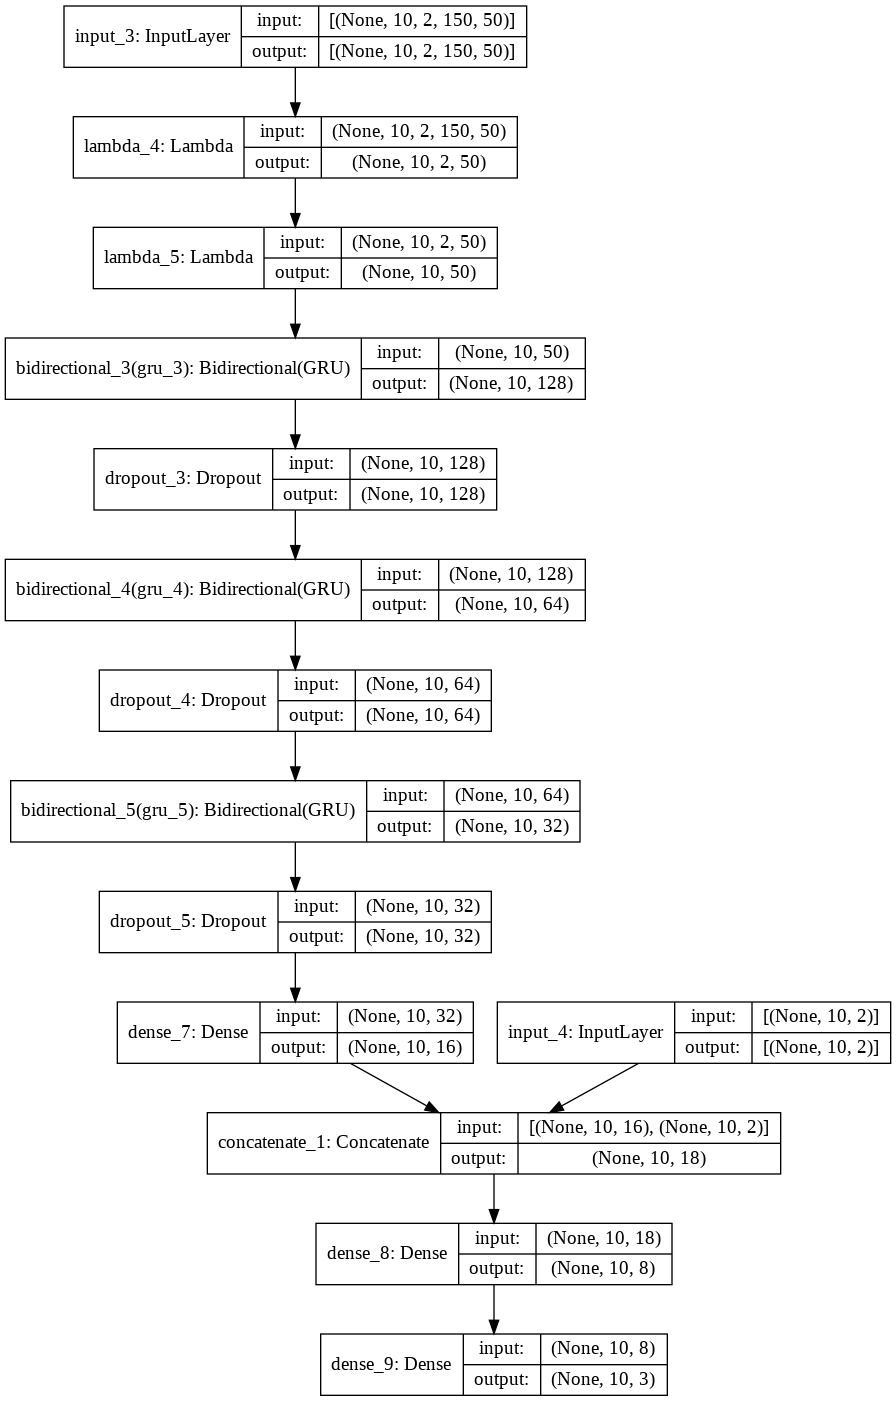

In [69]:
tf.keras.utils.plot_model(mymodel, show_shapes=True)

In [161]:
early = tf.keras.callbacks.EarlyStopping(patience=8)
best = tf.keras.callbacks.ModelCheckpoint("model_leo_02.h5", save_best_only=True, save_weights_only=True)
mymodel.fit(x=[train_utterances, train_features],
            y=oh_train_labels,
            # validation_data=([test_utterances, test_features], oh_test_labels),
            # validation_batch_size=20,
            validation_split=0.1,
            callbacks=[early, best],
            epochs=100,
            batch_size=BATCH_SIZE
            )

ValueError: ignored

In [79]:
 train_features

array([list([]),
       list([[4.5, 2.0], [4.0, 4.0], [3.0, 6.0], [3.0, 8.0], [3.0, 10.0], [2.5, 12.0], [3.0, 14.0], [4.0, 16.0], [4.0, 18.0], [3.5, 20.0]]),
       list([[3.5, 2.0], [4.0, 4.0], [3.0, 6.0], [3.0, 8.0], [2.5, 10.0], [3.5, 12.0], [4.0, 14.0], [2.0, 16.0], [1.5, 18.0], [3.5, 20.0]]),
       list([[4.5, 2.0], [5.0, 4.0], [3.0, 6.0], [2.5, 8.0], [7.0, 10.0], [4.5, 12.0], [4.0, 14.0], [3.5, 16.0], [4.0, 18.0], [4.0, 20.0]]),
       list([[2.0, 2.0], [3.0, 4.0], [2.5, 6.0], [4.0, 8.0], [1.5, 10.0], [1.5, 12.0], [2.0, 14.0], [3.0, 16.0], [3.5, 18.0], [2.5, 20.0]]),
       list([[2.0, 1.0], [2.0, 3.0], [4.5, 5.0], [3.5, 7.0], [2.5, 9.0], [2.5, 11.0], [2.5, 13.0], [1.5, 15.0], [1.5, 17.0], [1.5, 19.0]]),
       list([[5.5, 2.0], [3.5, 4.0], [1.0, 6.0], [4.0, 8.0], [3.5, 10.0], [3.0, 12.0], [4.0, 14.0], [1.5, 16.0], [8.0, 18.0], [4.0, 20.0]]),
       list([[3.0, 1.0], [8.0, 3.0], [2.0, 5.0], [2.5, 7.0], [3.0, 9.0], [4.0, 11.0], [4.5, 13.0], [1.5, 15.0], [3.5, 17.0], [1.0, 19.0]])

In [ ]:
def resultArray(model, test, testPred):
    result ={}
    data = {}
    data['turns'] = []
    size = len(test)
    predictedProbas = model.predict(testPred).reshape(-1,3)
    predictedValues = np.argmax(predictedProbas, axis=-1)
    for i in range(size):
        data['dialogue-id'] = test[i]['dialogue-id']
        result[data['dialogue-id']] = data
        predictedValue = reverse_mapping[predictedValues[i]]
        predictedProba = predictedProbas[i]
        
        turn ={}
        turn['turn-index'] = int(test[i]['system-index'])
        turn['labels'] = []
        
        label ={}
        label['breakdown'] = predictedValue
        label['prob-O'] = predictedProba[0]
        label['prob-T'] = predictedProba[1]
        label['prob-X'] = predictedProba[2] 
        
        turn['labels'].append(label)        
        data['turns'].append(turn)
        if  i == size-1 or test[i]['file_name'] != test[i+1]['file_name']:
            data = {}
            data['turns'] = []
    return result

In [ ]:
final_model = mymodel
final_model.load_weights("model_leo_02.h5")

predicted = resultArray(final_model, PrepareDataSet(json_dev_test), [test_utterances, test_features])
output = evaluationAsDict(eval_data_path, predicted, 0.5)

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1507
T Label Num : 		187
X Label Num : 		306

######### Results #########
Accuracy : 		0.214500 (429/2000)

Precision (X) : 	0.160666 (299/1861)
Recall    (X) : 	0.977124 (299/306)
F-measure (X) : 	0.275958

Precision (T+X) : 	0.662547 (1233/1861)
Recall    (T+X) : 	0.969340 (1233/1272)
F-measure (T+X) : 	0.787105

JS divergence (O,T,X) : 	0.231243
JS divergence (O,T+X) : 	0.078076
JS divergence (O+T,X) : 	0.201575

Mean squared error (O,T,X) : 	0.135834
Mean squared error (O,T+X) : 	0.091361
Mean squared error (O+T,X) : 	0.236905
###########################


## New Approach - MSE

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip

In [106]:
EMBEDDING_DIM = 50
MAX_LENGTH = 150
MAX_LEN_DIALOGUE = 10
BATCH_SIZE = 10
TRUNC_TYPE = 'post'
PADDING_TYPE = 'post'

In [107]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

def preprocess_text(text):
    text = text.lower()
    cleaned = re.sub(r"[^'\w\s]", " ", text)
    cleaned = re.sub(r"\s\s", " ", cleaned).strip()
    cleaned = " ".join([w for w in cleaned.split() if w not in stopwords])
    return cleaned

In [108]:
embeddings_index = {}
with open(f'glove.6B.{EMBEDDING_DIM}d.txt') as f:
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs

# from gensim.models import KeyedVectors
# word2vecGoogleNewsVectors = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
# w2v = KeyedVectors.load_word2vec_format(word2vecGoogleNewsVectors, binary=True)
# embeddings_index = {}
# for w in w2v.vocab.keys():
#   embeddings_index[w] = w2v.get_vector(w)
# del w2v
# del word2vecGoogleNewsVectors

In [109]:
label_mapping = {
    'O': 0,
    'T': 1,
    'X': 2,
    'extra': 3
}
reverse_mapping = {v:k for k, v in label_mapping.items()}

train_utterances = []
train_features = []
train_labels = []
cur_dialogue = 'Bot002_059'
dialogue = []
current_dialogue_labels = []
new_features = []
for info in tqdm(PrepareDataSet(json_dev_dev)):
  if info['dialogue-id']!=cur_dialogue:
    while len(dialogue)<MAX_LEN_DIALOGUE:
      dialogue.append([np.zeros((MAX_LENGTH, EMBEDDING_DIM)), np.zeros((MAX_LENGTH, EMBEDDING_DIM))])
      current_dialogue_labels.append(label_mapping["extra"])
    train_utterances.append(dialogue)
    train_labels.append(current_dialogue_labels)
    train_features.append(new_features)
    dialogue = []
    current_dialogue_labels = []
    new_features = []
    cur_dialogue = info['dialogue-id']
  user = preprocess_text(info['user-utterance'])
  user_tokens = tokenize.word_tokenize(user)
  user = user_tokens+["<oov>"]*(MAX_LENGTH-len(user_tokens))
  user = [embeddings_index.get(w, np.zeros(EMBEDDING_DIM)) for w in user]
  system = preprocess_text(info['system-utterance'])
  system_tokens = tokenize.word_tokenize(system)
  system = system_tokens+["<oov>"]*(MAX_LENGTH-len(system_tokens))
  system = [embeddings_index.get(w, np.zeros(EMBEDDING_DIM)) for w in system]
  mean_len = (len(system_tokens)+len(user_tokens))/2.0
  index = (info["user-index"]+info["system-index"])/2.0
  new_features.append([mean_len, index])
  dialogue.append([user, system])
  current_dialogue_labels.append([info['O'], info['T'], info['X']])

while len(dialogue)<MAX_LEN_DIALOGUE:
  dialogue.append([np.zeros((MAX_LENGTH, EMBEDDING_DIM)), np.zeros((MAX_LENGTH, EMBEDDING_DIM))])
  current_dialogue_labels.append(label_mapping["extra"])
train_utterances.append(dialogue)
train_labels.append(current_dialogue_labels)
train_features.append(new_features)
dialogue = []
current_dialogue_labels = []
cur_dialogue = info['dialogue-id']

test_utterances = []
test_features = []
test_labels = []
cur_dialogue = 'Bot001_023'
dialogue = []
current_dialogue_labels = []
new_features = []
for info in tqdm(PrepareDataSet(json_dev_test)):
  if info['dialogue-id']!=cur_dialogue:
    while len(dialogue)<MAX_LEN_DIALOGUE:
      dialogue.append([np.zeros((MAX_LENGTH, EMBEDDING_DIM)), np.zeros((MAX_LENGTH, EMBEDDING_DIM))])
      current_dialogue_labels.append(label_mapping["extra"])
    test_utterances.append(dialogue)
    test_labels.append(current_dialogue_labels)
    test_features.append(new_features)
    dialogue = []
    current_dialogue_labels = []
    new_features = []
    cur_dialogue = info['dialogue-id']
  user = preprocess_text(info['user-utterance'])
  user_tokens = tokenize.word_tokenize(user)
  user = user_tokens+["<oov>"]*(MAX_LENGTH-len(user_tokens))
  user = [embeddings_index.get(w, np.zeros(EMBEDDING_DIM)) for w in user]
  system = preprocess_text(info['system-utterance'])
  system_tokens = tokenize.word_tokenize(system)
  system = system_tokens+["<oov>"]*(MAX_LENGTH-len(system_tokens))
  system = [embeddings_index.get(w, np.zeros(EMBEDDING_DIM)) for w in system]
  mean_len = (len(system_tokens)+len(user_tokens))/2.0
  index = (info["user-index"]+info["system-index"])/2.0
  new_features.append([mean_len, index])
  dialogue.append([user, system])
  current_dialogue_labels.append([info['O'], info['T'], info['X']])

while len(dialogue)<MAX_LEN_DIALOGUE:
  dialogue.append([np.zeros((MAX_LENGTH, EMBEDDING_DIM)), np.zeros((MAX_LENGTH, EMBEDDING_DIM))])
  current_dialogue_labels.append(label_mapping["extra"])
test_utterances.append(dialogue)
test_labels.append(current_dialogue_labels)
test_features.append(new_features)
dialogue = []
current_dialogue_labels = []
cur_dialogue = info['dialogue-id']

train_features = np.array(train_features)
train_features = train_features/np.max(train_features, axis=0)
train_utterances = np.array(train_utterances)
train_labels = np.array(train_labels)
test_utterances = np.array(test_utterances)
test_features = np.array(test_features)
test_features = test_features/np.max(train_features, axis=0)
test_labels = np.array(test_labels)

100%|██████████| 2000/2000 [00:01<00:00, 1491.68it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


ValueError: ignored

In [ ]:
train_utterances.shape

(626, 10, 2, 150, 50)

In [ ]:
train_labels.shape

(626, 10, 3)

In [ ]:
input = tf.keras.layers.Input(shape=(MAX_LEN_DIALOGUE, 2, MAX_LENGTH, EMBEDDING_DIM))
x = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=-2))(input)
x = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=-2))(x)
for n in [64, 32, 16]:
  x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(n, return_sequences=True))(x)
  x = tf.keras.layers.Dropout(0.2)(x)
input2 = tf.keras.layers.Input(shape=(MAX_LEN_DIALOGUE, 2))
x = tf.keras.layers.Dense(16, activation="relu")(x)
x = tf.keras.layers.concatenate([x, input2], axis=-1)
x = tf.keras.layers.Dense(8, activation="relu")(x)
output = tf.keras.layers.Dense(3, activation="softmax")(x)
mymodel = tf.keras.Model(inputs=[input, input2], outputs=output)

mymodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mse")
mymodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10, 2, 150,  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 10, 2, 50)    0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 10, 50)       0           lambda_3[0][0]                   
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 10, 128)      44544       lambda_4[0][0]                   
____________________________________________________________________________________________

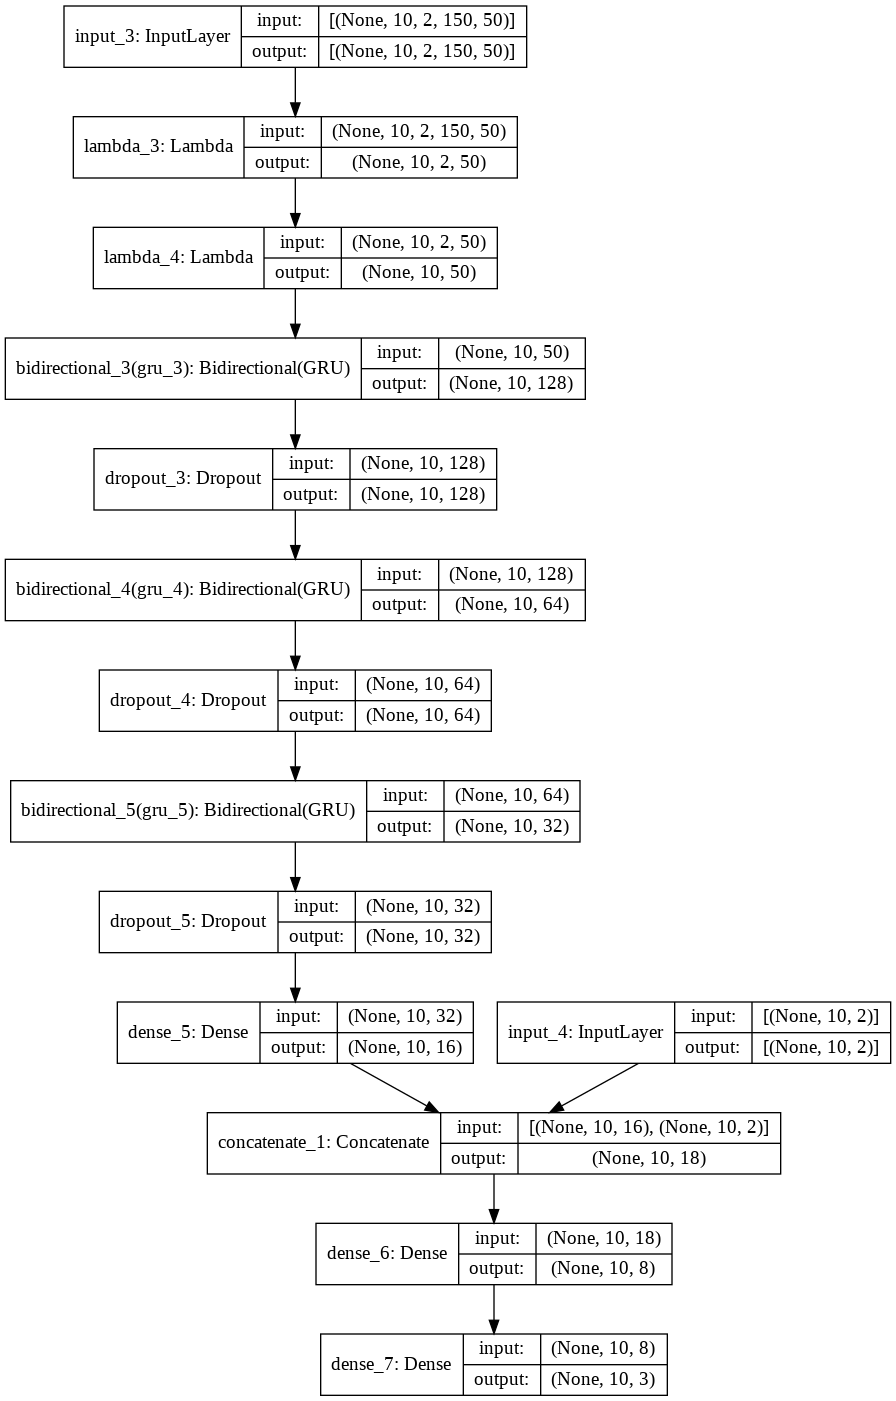

In [ ]:
tf.keras.utils.plot_model(mymodel, show_shapes=True)

In [ ]:
early = tf.keras.callbacks.EarlyStopping(patience=5)
best = tf.keras.callbacks.ModelCheckpoint("model_leo_03.h5", save_best_only=True, save_weights_only=True)
mymodel.fit(x=[train_utterances, train_features],
            y=train_labels,
            validation_data=([test_utterances, test_features], test_labels),
            validation_batch_size=10,
            # validation_split=0.1,
            callbacks=[early, best],
            epochs=100, 
            batch_size=BATCH_SIZE
            )

Epoch 1/100
63/63 [==============================] - 9s 39ms/step - loss: 0.0334 - val_loss: 0.1766
Epoch 2/100
63/63 [==============================] - 1s 16ms/step - loss: 0.0301 - val_loss: 0.1662
Epoch 3/100
63/63 [==============================] - 1s 16ms/step - loss: 0.0301 - val_loss: 0.1584
Epoch 4/100
63/63 [==============================] - 1s 16ms/step - loss: 0.0302 - val_loss: 0.1543
Epoch 5/100
63/63 [==============================] - 1s 16ms/step - loss: 0.0286 - val_loss: 0.1552
Epoch 6/100
63/63 [==============================] - 1s 16ms/step - loss: 0.0287 - val_loss: 0.1484
Epoch 7/100
63/63 [==============================] - 1s 16ms/step - loss: 0.0284 - val_loss: 0.1458
Epoch 8/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0273 - val_loss: 0.1497
Epoch 9/100
63/63 [==============================] - 1s 16ms/step - loss: 0.0275 - val_loss: 0.1509
Epoch 10/100
63/63 [==============================] - 1s 16ms/step - loss: 0.0255 - val_loss: 0.1450

In [ ]:
def resultArray(model, test, testPred):
    result ={}
    data = {}
    data['turns'] = []
    size = len(test)
    predictedProbas = model.predict(testPred).reshape(-1,3)
    predictedValues = np.argmax(predictedProbas, axis=-1)
    for i in range(size):
        data['dialogue-id'] = test[i]['dialogue-id']
        result[data['dialogue-id']] = data
        predictedValue = reverse_mapping[predictedValues[i]]
        predictedProba = predictedProbas[i]
        
        turn ={}
        turn['turn-index'] = int(test[i]['system-index'])
        turn['labels'] = []
        
        label ={}
        label['breakdown'] = predictedValue
        label['prob-O'] = predictedProba[0]
        label['prob-T'] = predictedProba[1]
        label['prob-X'] = predictedProba[2] 
        
        turn['labels'].append(label)        
        data['turns'].append(turn)
        
        if  i == size-1 or test[i]['file_name'] != test[i+1]['file_name']:
            data = {}
            data['turns'] = []
    return result

In [ ]:
final_model = mymodel
final_model.load_weights("model_leo_03.h5")

predicted = resultArray(final_model, PrepareDataSet(json_dev_test), [test_utterances, test_features])
output = evaluationAsDict(eval_data_path, predicted, 0)

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1507
T Label Num : 		187
X Label Num : 		306

######### Results #########
Accuracy : 		0.274500 (549/2000)

Precision (X) : 	0.170760 (292/1710)
Recall    (X) : 	0.954248 (292/306)
F-measure (X) : 	0.289683

Precision (T+X) : 	0.687135 (1175/1710)
Recall    (T+X) : 	0.923742 (1175/1272)
F-measure (T+X) : 	0.788062

JS divergence (O,T,X) : 	0.196004
JS divergence (O,T+X) : 	0.058862
JS divergence (O+T,X) : 	0.152334

Mean squared error (O,T,X) : 	0.108446
Mean squared error (O,T+X) : 	0.069424
Mean squared error (O+T,X) : 	0.178020
###########################


In [ ]:
dict = {}
for p in predicted:
    for t in predicted[p]['turns']:
        dict[p + '-' + str(t['turn-index'])]= t['labels'][0]['breakdown']
json.dumps(dict)

'{"Bot001_023-2": "O", "Bot001_023-4": "X", "Bot001_023-6": "X", "Bot001_023-8": "X", "Bot001_023-10": "X", "Bot001_023-12": "X", "Bot001_023-14": "X", "Bot001_023-16": "X", "Bot001_023-18": "X", "Bot001_023-20": "X", "Bot003_080-2": "O", "Bot003_080-4": "X", "Bot003_080-6": "X", "Bot003_080-8": "O", "Bot003_080-10": "X", "Bot003_080-12": "X", "Bot003_080-14": "X", "Bot003_080-16": "X", "Bot003_080-18": "X", "Bot003_080-20": "X", "Bot001_066-2": "O", "Bot001_066-4": "X", "Bot001_066-6": "X", "Bot001_066-8": "X", "Bot001_066-10": "X", "Bot001_066-12": "X", "Bot001_066-14": "X", "Bot001_066-16": "X", "Bot001_066-18": "X", "Bot001_066-20": "X", "iris_DBDC4_098-2": "O", "iris_DBDC4_098-4": "X", "iris_DBDC4_098-6": "X", "iris_DBDC4_098-8": "X", "iris_DBDC4_098-10": "X", "iris_DBDC4_098-12": "X", "iris_DBDC4_098-14": "X", "iris_DBDC4_098-16": "X", "iris_DBDC4_098-18": "X", "iris_DBDC4_098-20": "X", "Bot004_090-2": "X", "Bot004_090-4": "X", "Bot004_090-6": "X", "Bot004_090-8": "X", "Bot004_09